In [1]:
#!rm saccade_analysis_data.hdf5 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 
import pylab as plb
import numpy as np
import scipy as sp
import flylib as flb
import group_data as gd
import plotfuncs as plf
plb.rcParams['pdf.fonttype'] = 42
plb.rcParams['image.interpolation'] = 'nearest'
plb.rcParams['image.aspect'] = 'auto'
plb.rcParams['image.cmap'] = 'BrBG'
import h5py
demo_mode = False
import warnings
warnings.filterwarnings('ignore')

In [3]:
def filter_mtrx_linear(lmr_mtrx,lc,hc):
    """fiter left-right data using a bandpass filter"""
    return np.apply_along_axis(flb.butter_bandpass_filter,1,lmr_mtrx,lc,hc,0.021)

def filter_mtrx_nonlinear(lmr_mtrx,kernel_size=12,mysize=21):
    """filter using a median filter followed by wiener filter"""
    from scipy import signal
    trenddata = np.apply_along_axis(signal.medfilt,1,lmr_mtrx,kernel_size = kernel_size)
    detrend = lmr_mtrx-trenddata
    detrend[np.isnan(detrend)] = 0
    return np.apply_along_axis(signal.wiener,1,detrend,mysize =mysize)
    
def detect_saccades(lmr_mtrx,p0=0.5,p1=2,thresh=0.2,linear = True):
    """filter data then detect saccades over some threshold"""
    if linear:
        sac_band = filter_mtrx_linear(lmr_mtrx,p0,p1)
    else:
        sac_band = filter_mtrx_nonlinear(lmr_mtrx,p0,p1)
    event_lists = [flb.idx_by_thresh(sweep,thresh) for sweep in abs(sac_band)]
    event_lists = [[event for event in event_list if 
                    (len(event)>0) and not(event is None)] for event_list in event_lists if event_list]
    return event_lists,sac_band

def convert_events_to_mtrx(event_lists,output_shape,scalings = 1):
    """loop through the detected events to create a matrix of binary
    classified samples - output shape should match the dimensions matrix
    of wingstroke data that was input to the detect_saccades function"""
    event_mtrx = np.zeros(output_shape)
    if type(scalings) is list:
        for i,(elist,slist) in enumerate(zip(event_lists,scalings)):
            for event,scailing in zip(elist,slist):
                event_mtrx[i,event] = scailing
        return event_mtrx
    for i,elist in enumerate(event_lists):
        for event in elist:
            event_mtrx[i,event] = scalings
    return (event_mtrx > 0)

def get_putative_saccade_mtrx(p0,p1,thresh,linear = True):
    """apply detect_saccades and then convert to matrix use to evaluate true positive
    and false positive rates"""
    putative_saccades = detect_saccades(ground_truth_lmr,p0,p1,thresh,linear)
    putative_saccade_mtrx = convert_events_to_mtrx(putative_saccades[0],np.shape(ground_truth_lmr))
    return (putative_saccade_mtrx > 0)

In [4]:
#store the selected filter setting in a dictionary. Pickle for later use
import cPickle
#with open('chosen_fiter_settings.cpkl','wb') as f:
#    cPickle.dump(chosen_settings,f)
with open('chosen_filter_settings.cpkl','rb') as f:
    chosen_settings = cPickle.load(f)

#### To find the peak we first find the shortest distance from each point in the saccade to a line running from the beginning to the end of the detected event.

In [5]:
def event_distances(event,lmr):
    """find the shortest distance from each point in the saccade to 
    a line running from the beginning to the end of the detected event."""
    v = [(event[-1]-event[-0]),(lmr[event[-1]]-lmr[event[0]])*-1]
    distances = np.zeros_like(event).astype(float)
    for pnt_idx in event:
        r = [lmr[pnt_idx]-lmr[event[0]],pnt_idx-event[0]]
        distances[pnt_idx-event[0]] = np.dot(r,v/np.linalg.norm(v))
    return distances

def event_peaks(event,distances):
    """use the calculated distances to find the peak of the event"""
    return np.argmax(np.abs(distances))+ event[0]

In [6]:
#funny syntax to to replace mode with true or false kwarg
filter_settings = dict()
filter_settings['linear'] = {'linear':True,'non_linear':False}[chosen_settings['mode']]
filter_settings['p0'] = chosen_settings['ksizes']
filter_settings['p1'] = chosen_settings['mysizes']
filter_settings['thresh'] = chosen_settings['thresh_vals']

In [7]:
filter_settings

{'linear': False, 'p0': 81, 'p1': 34, 'thresh': 0.15384615384615385}

In [8]:
mtd_22H05 = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db_22H05.hdf5','r')
mtd_39E01 = h5py.File('../05_basic_open_loop_motion/open_loop_trial_db_39E01.hdf5','r')

In [9]:
filter_mode = {True:'linear',False:'non_linear'}[filter_settings['linear']]

In [10]:
#filter_settings = dict(chosen_settings)
#get the lmr datamatrix for all trials
#data_lmr_22H05 = np.array(mtd_22H05['normed_signals']['Ph2'])*np.array(mtd_22H05['signal_norms']['Ph2'])[:,None]
#data_lmr_39E01 = np.array(mtd_39E01['normed_signals']['Ph2'])*np.array(mtd_39E01['signal_norms']['Ph2'])[:,None]

data_lmr_22H05 = np.array(mtd_22H05['selected_signals']['Ph2'])#*np.array(mtd_22H05['signal_norms']['Ph2'])[:,None]
data_lmr_39E01 = np.array(mtd_39E01['selected_signals']['Ph2'])#*np.array(mtd_39E01['signal_norms']['Ph2'])[:,None]

#extract the saccade epochs
detected_saccades_22H05,saccade_band_22H05 = detect_saccades(data_lmr_22H05,**filter_settings)
detected_saccades_39E01,saccade_band_39E01 = detect_saccades(data_lmr_39E01,**filter_settings)

#calculate the distances for each event
saccade_distances_22H05 = [[event_distances(event,sweep) for 
                          event in event_list] for 
                                event_list,sweep in zip(detected_saccades_22H05,data_lmr_22H05)]

saccade_distances_39E01 = [[event_distances(event,sweep) for 
                              event in event_list] for 
                                event_list,sweep in zip(detected_saccades_39E01,data_lmr_39E01)]


#find the peaks - the index with the largest distance
saccade_peaks_22H05 = [[event_peaks(event,distances) for 
                      event,distances in zip(event_list,distances_list)] for 
                           event_list,distances_list in zip(detected_saccades_22H05,saccade_distances_22H05)]

saccade_peaks_39E01 = [[event_peaks(event,distances) for 
                          event,distances in zip(event_list,distances_list)] for 
                               event_list,distances_list in zip(detected_saccades_39E01,saccade_distances_39E01)]


#create a bool matrix with the detected saccades
detected_saccade_mtrx_22H05 = convert_events_to_mtrx(detected_saccades_22H05,
                                               np.shape(data_lmr_22H05),
                                               scalings = saccade_distances_22H05)

detected_saccade_mtrx_39E01 = convert_events_to_mtrx(detected_saccades_39E01,
                                                     np.shape(data_lmr_39E01),
                                                     scalings = saccade_distances_39E01)

#### visualization of the processing stages applied to raster images of the full dataset

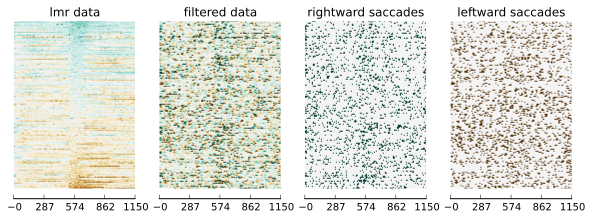

In [11]:
plb.figure(figsize = (10,3))
plb.subplot(1,4,1)
plb.imshow(data_lmr_39E01,vmin = -6, vmax = 6)
plf.pull_ax_spines(left= False)
plb.gca().set_title('lmr data')

plb.subplot(1,4,2)
plb.imshow(saccade_band_39E01,vmin = -4*filter_settings['thresh'], vmax = 4*filter_settings['thresh'])
plf.pull_ax_spines(left= False)
plb.gca().set_title('filtered data')

plb.subplot(1,4,3)
plb.imshow(detected_saccade_mtrx_39E01>0,vmin = -1, vmax = 1)
plf.pull_ax_spines(left= False)
plb.gca().set_title('rightward saccades')

plb.subplot(1,4,4)
plb.imshow(-1*(detected_saccade_mtrx_39E01<0),vmin = -1, vmax = 1)
plf.pull_ax_spines(left= False)
plb.gca().set_title('leftward saccades');

### make a series of data tables to hold each of the saccades - select 20 samples (420ms) before the saccade event and 50 samples (1050ms) after the event

In [12]:
## for 22H05

saccade_list = list()
pre_samp = 50
post_samp = 50
xi = gd.get_xio('yaw_left')
last_samp = np.argwhere(xi > 10)[0]
from ipywidgets import FloatProgress
from IPython.display import display
progress_bar = FloatProgress(min = 0,max = len(saccade_peaks_22H05))
display(progress_bar)

for row,event_list,distances_list,peaks_list in zip(np.arange(len(saccade_peaks_22H05)),
                                                    detected_saccades_22H05,
                                                    saccade_distances_22H05,
                                                    saccade_peaks_22H05):
    for event,distances,peak in zip(event_list,distances_list,peaks_list):
        try:
            if len(event)>5:
                idx = np.arange(peak-pre_samp,peak+post_samp)
                if idx[-1]<np.shape(saccade_band_22H05)[1]:
                    saccade_list.append([event,distances,peak,row,
                               saccade_band_22H05[row,idx],
                               mtd_22H05['normed_signals']['Ph0'][row,idx],
                               mtd_22H05['normed_signals']['Ph1'][row,idx],
                               mtd_22H05['normed_signals']['Ph2'][row,idx],
                               mtd_22H05['normed_signals']['b1'][row,idx],
                               mtd_22H05['normed_signals']['b2'][row,idx],
                               mtd_22H05['normed_signals']['b3'][row,idx],
                               mtd_22H05['normed_signals']['i1'][row,idx],
                               mtd_22H05['normed_signals']['i2'][row,idx],
                               mtd_22H05['normed_signals']['iii1'][row,idx],
                               mtd_22H05['normed_signals']['iii24'][row,idx],
                               mtd_22H05['normed_signals']['iii3'][row,idx],
                               mtd_22H05['normed_signals']['hg1'][row,idx],
                               mtd_22H05['normed_signals']['hg2'][row,idx],
                               mtd_22H05['normed_signals']['hg3'][row,idx],
                               mtd_22H05['normed_signals']['hg4'][row,idx],
                               mtd_22H05['normed_signals']['pr'][row,idx],
                               mtd_22H05['normed_signals']['nm'][row,idx],
                               mtd_22H05['selected_signals']['fly_numbers'][row],
                               mtd_22H05['selected_signals']['trial_names'][row],
                               xi[idx],
                               mtd_22H05['signal_norms']['Ph0'][row],
                               mtd_22H05['signal_means']['Ph0'][row],
                               mtd_22H05['signal_norms']['Ph1'][row],
                               mtd_22H05['signal_means']['Ph1'][row],
                               mtd_22H05['signal_norms']['Ph2'][row],
                               mtd_22H05['signal_means']['Ph2'][row],
                               mtd_22H05['selected_signals']['Ph0'][row,idx],
                               mtd_22H05['selected_signals']['Ph1'][row,idx],
                               mtd_22H05['selected_signals']['Ph2'][row,idx],])
                else:
                    pass #event cliped at end of trial
        except ValueError:
            pass
    progress_bar.value = row

### save the dictionary to disk
if demo_mode:
    pass
else:
    import os
    if filter_mode is 'linear':
        try:
            os.remove('detected_saccades_lin_22H05.hdf5')
        except OSError:
            pass
        saccade_tables = h5py.File('detected_saccades_nl_22H05.hdf5','a')
    else:
        try:
            os.remove('detected_saccades_nl_22H05.hdf5')
        except OSError:
            pass
        saccade_tables = h5py.File('detected_saccades_nl_22H05.hdf5','a')
    for i,dset_name in enumerate(['peak','row','filtered','Ph0','Ph1','Ph2',
                              'b1','b2','b3','i1','i2','iii1','iii24','iii3',
                              'hg1','hg2','hg3','hg4','pr','nm',
                              'fly_numbers','trial_names','xi',
                             'lwing_norm','lwing_mean','rwing_norm','rwing_mean',
                             'lmr_norms','lmr_mean',
                             'lwing_natural','rwing_natural','lmr_natural']):
        saccade_tables.create_dataset(dset_name, data = np.array([x[i+2] for x in saccade_list]),
                                         compression = 'gzip')
    saccade_tables.flush()
    saccade_tables.close()

In [13]:
## for 39E01

saccade_list_39E01 = list()
pre_samp = 50
post_samp = 50
xi = gd.get_xio('yaw_left')
from ipywidgets import FloatProgress
from IPython.display import display
progress_bar = FloatProgress(min = 0,max = len(saccade_peaks_39E01))
display(progress_bar)

for row,event_list,distances_list,peaks_list in zip(np.arange(len(saccade_peaks_39E01)),
                                                    detected_saccades_39E01,
                                                    saccade_distances_39E01,
                                                    saccade_peaks_39E01):
    for event,distances,peak in zip(event_list,distances_list,peaks_list):
        try:
            if len(event)>5:
                idx = np.arange(peak-pre_samp,peak+post_samp)
                if idx[-1]<np.shape(saccade_band_39E01)[1]:
                    saccade_list_39E01.append([event,distances,peak,row,
                               saccade_band_39E01[row,idx],
                               mtd_39E01['normed_signals']['Ph0'][row,idx],
                               mtd_39E01['normed_signals']['Ph1'][row,idx],
                               mtd_39E01['normed_signals']['Ph2'][row,idx],
                               mtd_39E01['normed_signals']['b1'][row,idx],
                               mtd_39E01['normed_signals']['b2'][row,idx],
                               mtd_39E01['normed_signals']['b3'][row,idx],
                               mtd_39E01['normed_signals']['iii1'][row,idx],
                               mtd_39E01['normed_signals']['iii24'][row,idx],
                               mtd_39E01['normed_signals']['iii3'][row,idx],
                               mtd_39E01['normed_signals']['hg1'][row,idx],
                               mtd_39E01['normed_signals']['hg2'][row,idx],
                               mtd_39E01['normed_signals']['hg3'][row,idx],
                               mtd_39E01['normed_signals']['hg4'][row,idx],
                               mtd_39E01['selected_signals']['fly_numbers'][row],
                               mtd_39E01['selected_signals']['trial_names'][row],
                               xi[idx],
                               mtd_39E01['signal_norms']['Ph0'][row],
                               mtd_39E01['signal_means']['Ph0'][row],
                               mtd_39E01['signal_norms']['Ph1'][row],
                               mtd_39E01['signal_means']['Ph1'][row],
                               mtd_39E01['signal_norms']['Ph2'][row],
                               mtd_39E01['signal_means']['Ph2'][row],
                               mtd_39E01['selected_signals']['Ph0'][row,idx],
                               mtd_39E01['selected_signals']['Ph1'][row,idx],
                               mtd_39E01['selected_signals']['Ph2'][row,idx],])
                else:
                    pass #event cliped at end of trial
        except ValueError:
            pass
    progress_bar.value = row

### save the dictionary to disk
if demo_mode:
    pass
else:
    import os
    if filter_mode is 'linear':
        try:
            os.remove('detected_saccades_lin_39E01.hdf5')
        except OSError:
            pass
        saccade_tables = h5py.File('detected_saccades_lin_39E01.hdf5','a')
    else:
        try:
            os.remove('detected_saccades_nl_39E01.hdf5')
        except OSError:
            pass
        saccade_tables = h5py.File('detected_saccades_nl_39E01.hdf5','a')
    for i,dset_name in enumerate(['peak','row','filtered','Ph0','Ph1','Ph2',
                              'b1','b2','b3','iii1','iii24','iii3',
                              'hg1','hg2','hg3','hg4','fly_numbers','trial_names','xi',
                             'lwing_norm','lwing_mean','rwing_norm','rwing_mean',
                             'lmr_norms','lmr_mean',
                             'lwing_natural','rwing_natural','lmr_natural']):
        saccade_tables.create_dataset(dset_name, data = np.array([x[i+2] for x in saccade_list_39E01]),
                                         compression = 'gzip')
    saccade_tables.flush()
    saccade_tables.close()